#    Proiect licenta v. 1
##   Toate circuitele, algoritmii si testele 

In [40]:
from qiskit import Aer, QuantumCircuit
import matplotlib.pyplot as plt
import pandas as pd
import math
from statsmodels.stats.weightstats import ztest
from scipy import stats
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

# Prima parte - Distributie uniforma

### Ruleaza doar una dintre celulele cu circuite de mai jos!

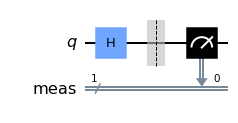

In [4]:
# Prima varianta - 800000 de rulari cu un singur qubit pentru 100000 nr pe 8 biti
# prima oara cu poarta Hadamard, a doua oara cu o rotatie de 90 de grade in jurul axei y
qc_uniform = QuantumCircuit(1) 
qc_uniform.h(0)
qc_uniform.measure_all()
qc_uniform.draw(output='mpl')

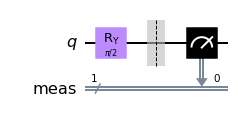

In [45]:
# A doua varianta - Rotatie generica cu 90 de grade in jurul axei y
# NB: se stie ca qubitii din qiskit sunt initializati in starea |0>!
qc_uniform = QuantumCircuit(1)
qc_uniform.ry(math.pi/2, 0)
qc_uniform.measure_all()
qc_uniform.draw(output='mpl')

In [46]:
sim = Aer.get_backend('aer_simulator')
result1 = sim.run(qc_uniform, shots=800000, memory=True).result()
counts1 = result1.get_counts()
memory1 = result1.get_memory()

In [47]:
# concatenam bitii aleatori 8 cate 8 pentru a obtine numere pe 8 biti
numbers1 = []
c = 0
temp = ''
for i in range(len(memory1)):
    temp = temp + memory1[i]
    c = c + 1
    if c == 8:
        numbers1.append(temp)
        temp = ''
        c = 0
numbers1 = [int(x, 2) for x in numbers1]
unique_numbers1 = list(set(numbers1))
my_counts1 = {x: numbers1.count(x) for x in unique_numbers1}
df1_data = {"number": my_counts1.keys(), "counts": my_counts1.values()} # dataframe pentru usurinta
df1 = pd.DataFrame.from_dict(df1_data)
df1


,number,counts
0,0,389
1,1,397
2,2,383
3,3,374
4,4,406
...,...,...
251,251,416
252,252,405
253,253,397
254,254,341


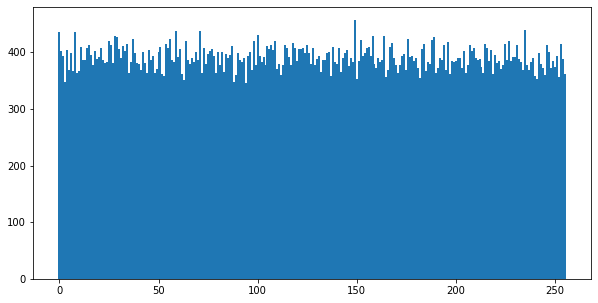

In [25]:
plt.bar(my_counts1.keys(), my_counts1.values(), width=1)
plt.show()

## Testul 1: test z vs. distributie uniforma aleatoare intre minim si maxim

In [38]:
dist_uniform = np.random.randint(df1['counts'].min(), df1['counts'].max(), len(df1))
numbers_dist_uniform = range(0, len(dist_uniform))
dict_dist_uniform = {numbers_dist_uniform[i]: dist_uniform[i] for i in range(len(dist_uniform))}
data_dist_uniform = {"number": dict_dist_uniform.keys(), "counts": dict_dist_uniform.values()}
df1_2 = pd.DataFrame.from_dict(data_dist_uniform)
z_calc = (df1['counts'].mean() - df1_2['counts'].mean()) / (math.sqrt(df1.var()['counts'] / len(df1['counts']) + df1_2.var()['counts'] / len(df1_2['counts'])))
z_calc

-5.885899723296371

In [39]:
'''
varianta din biblioteca statsmodels - primul numar este scorul Z, al doilea valoarea p
factor p foarte mic -> se respinge ipoteza nulului => cele doua esantioane sunt suficient de similare
'''
ztest(df1['counts'], df1_2['counts'])

(-5.885899723296371, 3.958943071358524e-09)

## Testul 2: test kologomorov-smirnov pentru a compara distributia cu una uniforma

In [43]:
'''
Din pacate, desi testul este cu siguranta cel mai potrivit pentru cerintele mele, 
nu am gasit nici o sursa de explicatie foarte buna a testului pentru a o implementa eu 
Asadar, voi folosi numai implementarea din scipy.stats
Din nou, valoare p mica -> se respinge ipoteza nulului -> 
-> cele doua distributii provin din aceeasi sursa
'''
stats.kstest(df1['counts'], df1_2['counts'])

KstestResult(statistic=0.30078125, pvalue=1.2759484876392345e-10)

# Partea a doua - Distributie normala